# Modified Version of Allison's Diffusion-Advection Model

In [1]:
#!pip install tqdm # <-- uncomment to install tqdm in your Docker image 

In [2]:
import tqdm

In [3]:
import firedrake
from firedrake import Constant, as_vector
import irksome
import matplotlib.pyplot as plt
import numpy as np
import heat_flow # This package is specifically written for this project

## Setting Up the Domain 

In [4]:
lx, lz = 20e3, 3e3 # Physical Length (lx) and Thickness (lz) in meters 

nz = 19*2 # Number of finite elements in z dir.
nx = 40*2 # Number of finite elements in x dir.

mesh = firedrake.RectangleMesh(nx, nz, lx, lz, diagonal="crossed") # Add hierarchy

cg1 = firedrake.FiniteElement("CG", "triangle", 1) # We're using piecewise linear cts Galerkin elements. More on this later. 
Q = firedrake.FunctionSpace(mesh, cg1)

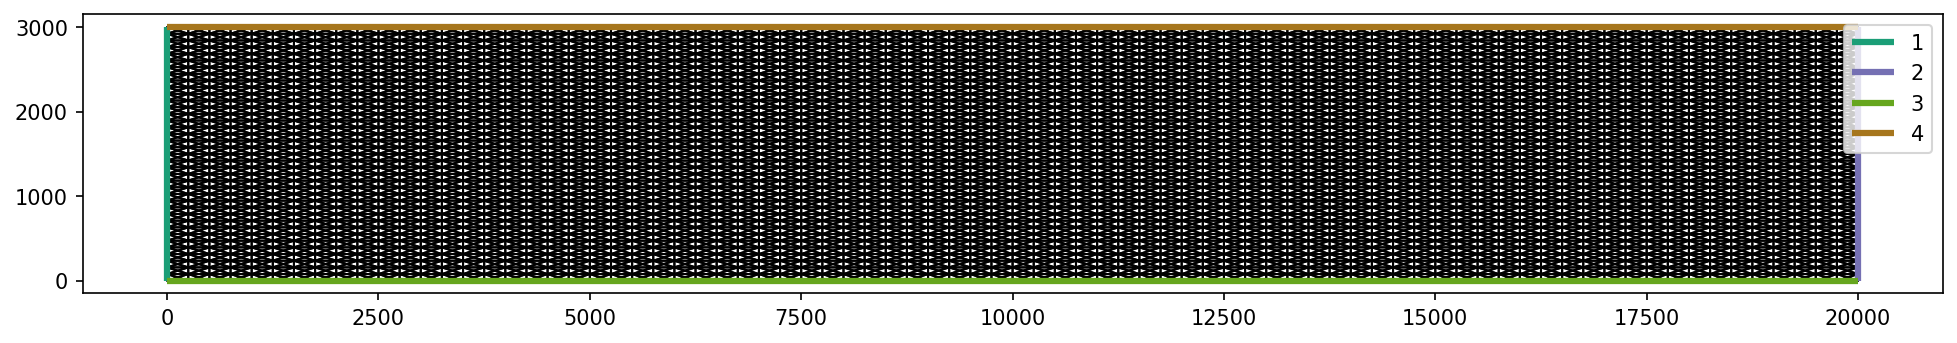

In [5]:
# Vizualizing the mesh, Useful for identifying boundaries

fig, ax = plt.subplots(figsize = (16, 8),dpi=150)
ax.set_aspect("equal")
firedrake.triplot(mesh, axes=ax, boundary_kw={"linewidth": 3.0})
ax.legend(loc="upper right");

## Setting and vizualizing the initial State of the domain:

In [6]:
ρ    = Constant(917)          # density of ice, [kg/m3]
s2yr = Constant(60*60*24*365) # convert seconds (for all constants etc) to years

In [7]:
# Setting the temperature profile to start the run:
T      = firedrake.Function(Q)             # create function space for T
x, z   = firedrake.SpatialCoordinate(mesh) # get spatial coords from mesh
Lx, Lz = Constant(lx), Constant(lz)        # get length in X and Z
ξ, ζ   = x / Lx, z / Lz                    # get these... idk... steps? 

T_b  = Constant(273 - 20.)  # intial base temp [K]
T_s  = Constant(273 - 55.)  # surface temp [K] -- from Cuffey and Paterson (2010) - average of their SP and Plateau values

T_in = (1 - ζ) * T_b + ζ * T_s # initial temperature of the ice [K]

T.interpolate(T_in) # interpolate the initial temperature profile onto the function space

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0xffff3d637f50>, FiniteElement('Lagrange', triangle, 1), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0)), 3)

In [8]:
# lol ok. so k is temperature dependant and our good friends Cuffey and Paterson actually have a cute little
# formula for this:
k = Constant(9.828)*firedrake.exp( (-5.7e-3) * (T) )*(s2yr)**3 # thermal conductivity in [kg m/ yr3 K]
k_proj = firedrake.Function(Q).interpolate(k) # projecting is just so that we can take a look at it

# and since we are going for broke, we might as well get c temperature dependant as well:
c = Constant(152.5) + 7.122*(T)*(s2yr)**2 # specific heat capacity yippee
c_proj = firedrake.Function(Q).interpolate(c) # projecting is just so that we can take a look at it

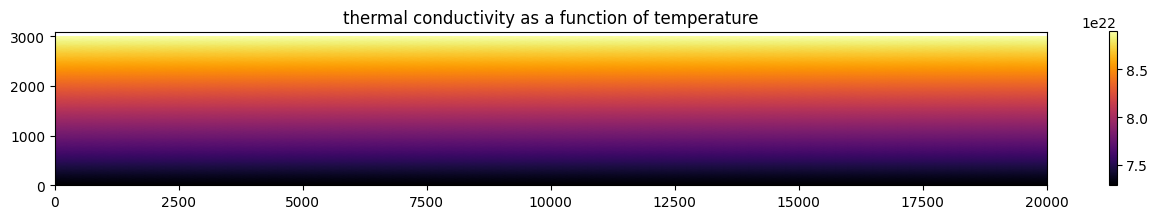

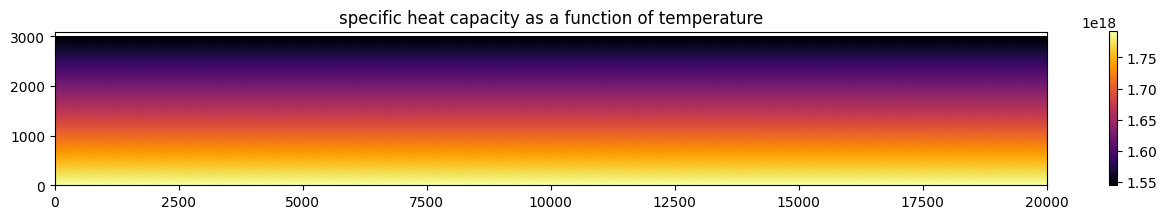

In [9]:
# um okay so plotting time it is, ladies:
fig, axes = plt.subplots(figsize=(16,10))
ks = firedrake.tripcolor(k_proj, cmap='inferno', axes=axes)
fig.colorbar(ks, location="right", shrink=0.2)
axes.set_aspect("equal")
axes.set_title("thermal conductivity as a function of temperature")
axes.set_xlim(0,20000)
axes.set_ylim(0,3100)
plt.show();

fig, axes = plt.subplots(figsize=(16,10))
cs = firedrake.tripcolor(c_proj, cmap='inferno', axes=axes)
fig.colorbar(cs, location="right", shrink=0.2)
axes.set_aspect("equal")
axes.set_title("specific heat capacity as a function of temperature")
axes.set_xlim(0,20000)
axes.set_ylim(0,3100)
plt.show();

In [10]:
###################################### BOX FOR ALLISON TO CHANGE THINGS IN ######################################

# "relaxation" constant for the surface heat flux/surface temperature:
σ_s = Constant(3e3)  # [m]

# geothermal (AKA basal) heat flux -- get the range for this value!!!
b_value = 40 # [mW/m2] -- gets converted in the q_b term
gthf = np.linspace(30,150,int((150-30)/5+1)) # range of geothermal heatfluxes in mW/m2, from 30 to 150, step size = 5

# heat source WITHIN the ice -- i.e., heat generated from shear heating, etc. Must be non-zero when using velocity!
q   = Constant(1e-6)*s2yr**3       # [W/m2] <-- !!! a fun dial to turn !!!

# basal heat flux (input to system via geothermal heat flux at base of the ice)
q_b = Constant(b_value*1e-3)*s2yr**3  # [W/m2] <-- mess around with this

# surface heat flux (enforced in the system using the surface temperature)
q_s = -σ_s * k * (T - T_s)  # [W/m2]

heater = q_s + q_b + q
heater2 = firedrake.Function(Q).interpolate(heater)

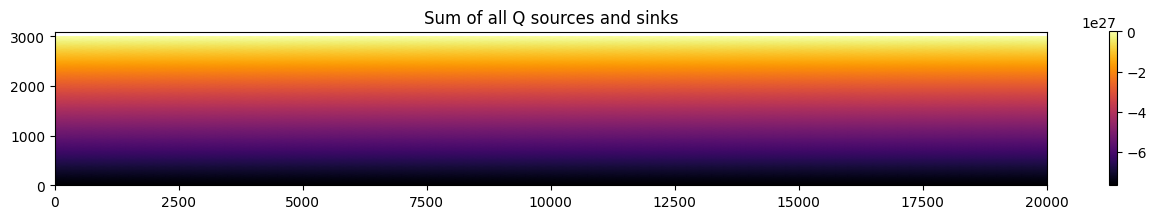

In [11]:
fig, axes = plt.subplots(figsize=(16,10))
heats = firedrake.tripcolor(heater2, cmap='inferno', axes=axes)
fig.colorbar(heats, location="right", shrink=0.2)
axes.set_aspect("equal")
axes.set_title("Sum of all Q sources and sinks")
axes.set_xlim(0,20000)
axes.set_ylim(0,3100)
plt.show();

In [12]:
inflow_id  = [1] # boundary ID for inflow
outflow_id = [2] # boundary ID for outflow
bed_id     = [3] # boundary ID for bed
surface_id = [4] # boundary ID for surface

# get a function space for the velocity :)
V = firedrake.VectorFunctionSpace(mesh, cg1)

################# Boundary Condition (BC) Time! #################
# SIA = Shallow Ice Approximation
# SIA means we assume the ice is frozen to the bed, so u_bed = 0

u_0 = Constant(1.0)  # initial horizontal velocity
w_0 = Constant(1e-3) # initial vert velocity -- IT'S POSITIVE AND IT PROBABLY SHOULDN'T BE

u_in  = as_vector((u_0 *(1 - (1- ζ)**2) + w_0*x /Lz, 0)) # velocity at the inflow boundary
u_bed = as_vector((0,0))               # SIA assumption (frozen to the bed, x vel = 0, z vel = 0)

# now we can make some boundary conditions:
bcs = [
    firedrake.DirichletBC(V, u_bed, bed_id),
    firedrake.DirichletBC(V, u_in, inflow_id),
    firedrake.DirichletBC(V, u_in, outflow_id)
]

In [13]:
# z  = spatial coord for the mesh
# lz = surface elevation
# using the above ^ info about z and lz:
u_h = 0*(1 - z/lz)**2 + u_0*(z/lz)**2  # horizontal velocity component
u_v = (-w_0)*ζ                         # vertical velocity component - NEW! it's positive now

u_expr = as_vector((u_0 *(1 - (1- ζ)**2) + w_0*x /Lz, 0)) #<-- from Jon/Daniel
#u_expr = as_vector(( u_0*(1 - (1-chi)**2) + w_0*x/Lz, -w_0*ζ )) <-- used to check against Jon's

#u_expr = as_vector((u_h, u_v)) # velocity expression for both horizontal and vertical
u = firedrake.Function(V).interpolate(u_expr)
n = firedrake.FacetNormal(mesh)

#prod = firedrake.inner(u,n)
#proj_prod = firedrake.Function(Q).interpolate(prod)
#minprod = firedrake.min_value(prod, 0)
#print(proj_prod)

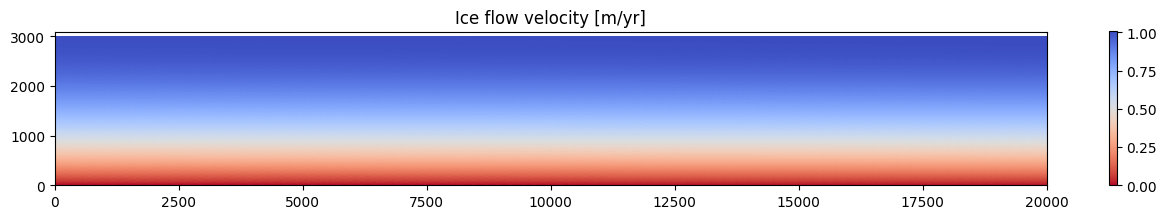

In [14]:
fig, axes = plt.subplots(figsize=(16,10))
vel_u = firedrake.tripcolor(u, cmap='coolwarm_r', axes=axes)
fig.colorbar(vel_u, location="right", shrink=0.2)
axes.set_aspect("equal")
axes.set_title("Ice flow velocity [m/yr]")
axes.set_xlim(0,20000)
axes.set_ylim(0,3100)
plt.show();

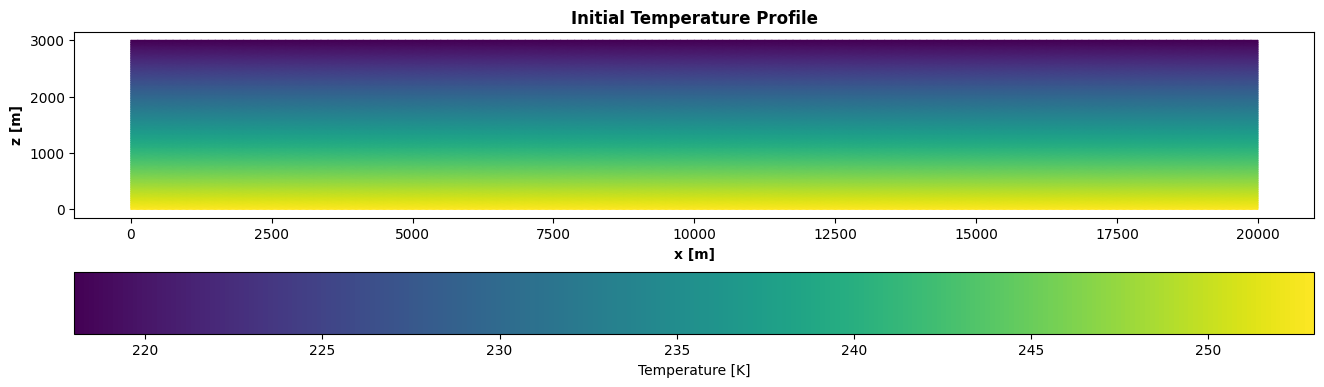

In [15]:
fig, ax = plt.subplots(figsize = (16,10))
colors = firedrake.tripcolor(T, axes=ax)
ax.set_title('Initial Temperature Profile', fontweight = 'bold')
ax.set_xlabel('x [m]',  fontweight = 'bold')
ax.set_ylabel('z [m]',  fontweight = 'bold')
axes.set_xlim(0,20000)
axes.set_ylim(0,3100)
fig.colorbar(colors, 
             orientation = 'horizontal', 
             label = 'Temperature [K]', 
             pad = 0.07
            )
ax.set_aspect("equal")
plt.show()

# once you have the range for all T_min and T_max, you can set vmin and vmax on this type of plot
# this will keep the changes understandable relative to each other 
# instead of the one above, use this line:
# colors = firedrake.tripcolor(T, axes=ax, vmin=<T_min>, vmax=<T_max>)

## Model Params, constants, and solver options

In [16]:
fields = {
    "temperature": T,
    "velocity": u,
    "temperature_in": T_in,
    "heat_source": q,
    "surface_flux": q_s,
    "basal_flux": q_b,
    "test_function": firedrake.TestFunction(Q),
}

parameters = {
    "density": ρ,
    "heat_capacity": c,
    "conductivity": k,
}

G = heat_flow.form_problem_cartesian(**fields, **parameters)

In [17]:
# Run length Inputs
#sec_per_year = 24 * 60 * 60 * 365.25 # unit conversion, [s] -> [yr]

t  = Constant(0.0)          # start time [yr]
dt = Constant(50) # time step size -- you can change this as-needed [yr]

final_time = 70000           # final time [yr] - can use to change length of run
num_steps  = int(final_time / float(dt)) # number of steps

In [18]:
# These are values we pull out during the run @ each time step
T_min = np.zeros(num_steps) * np.nan # initializes the T_min storage of length(num_steps)
T_max = np.zeros(num_steps) * np.nan # initializes the T_max storage of length(num_steps)

In [ ]:
method = irksome.BackwardEuler()
solver_parameters = {
    "pc_type": "lu",
    "snes_atol": 1e-6,
    "snes_rtol": 1e-1}
solver = irksome.TimeStepper(G, method, t, dt, T, solver_parameters=solver_parameters)

/opt/firedrake/firedrake/constant.py:74: FutureWarning: Giving Constants a domain is no longer supported. Instead please create a Function in the Real space.
  warnings.warn(


In [20]:
# The actual Loop
Ts = [T.copy(deepcopy=True)]

for step in tqdm.trange(num_steps):
    T_min[step] = T.dat.data_ro.min()
    T_max[step] = T.dat.data_ro.max()
    Ts.append(T.copy(deepcopy=True))
    solver.advance()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 1400/1400 [00:23<00:00, 60.74it/s]


In [21]:
print(T.dat.data_ro.min(), T.dat.data_ro.max())

218.000003441202 258.22966309129794


## Vizualing Results
### Feel free to add and improve plots here

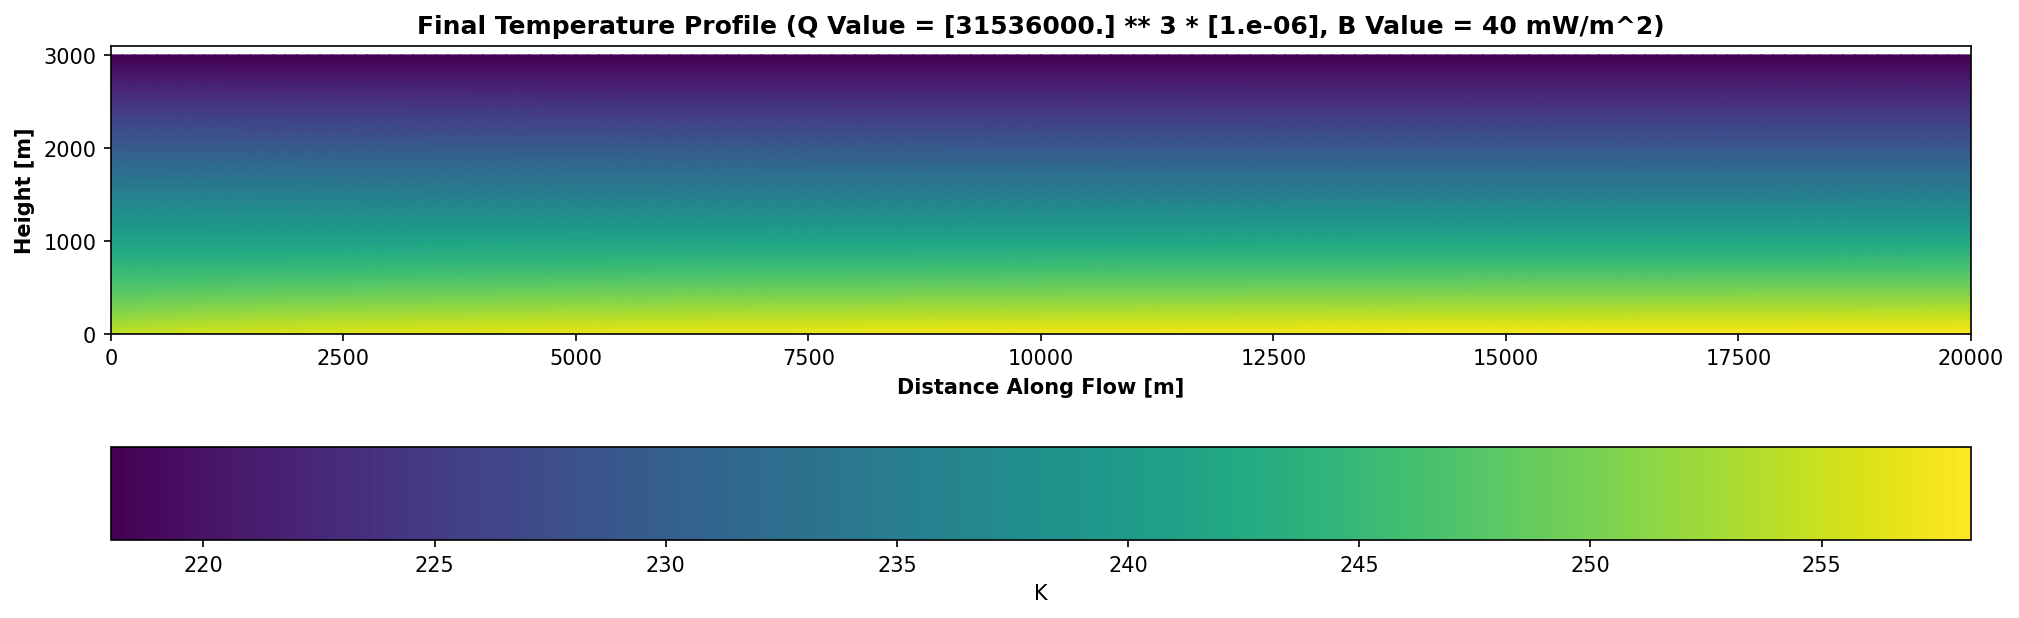

In [22]:
fig, ax = plt.subplots(figsize = (16,14),dpi=150)

colors = firedrake.tripcolor(Ts[-1],              
                             #vmax= 0,
                             #vmin = -40,
                             axes=ax)
ax.set_title(f"Final Temperature Profile (Q Value = {q}, B Value = {b_value} mW/m^2)", 
             fontweight = 'bold')
ax.set_xlabel('Distance Along Flow [m]',  fontweight = 'bold')
ax.set_ylabel('Height [m]',  fontweight = 'bold')
fig.colorbar(colors, 
             orientation = 'horizontal', 
             label = 'K', 
             pad = 0.07
            )
ax.set_aspect("equal")
ax.set_xlim(0,20000)
ax.set_ylim(0,3100)
#plt.savefig('q-val-0_b-val-90_tempprof.png', bbox_inches='tight', transparent=True) #q val,source fig name 
plt.show();

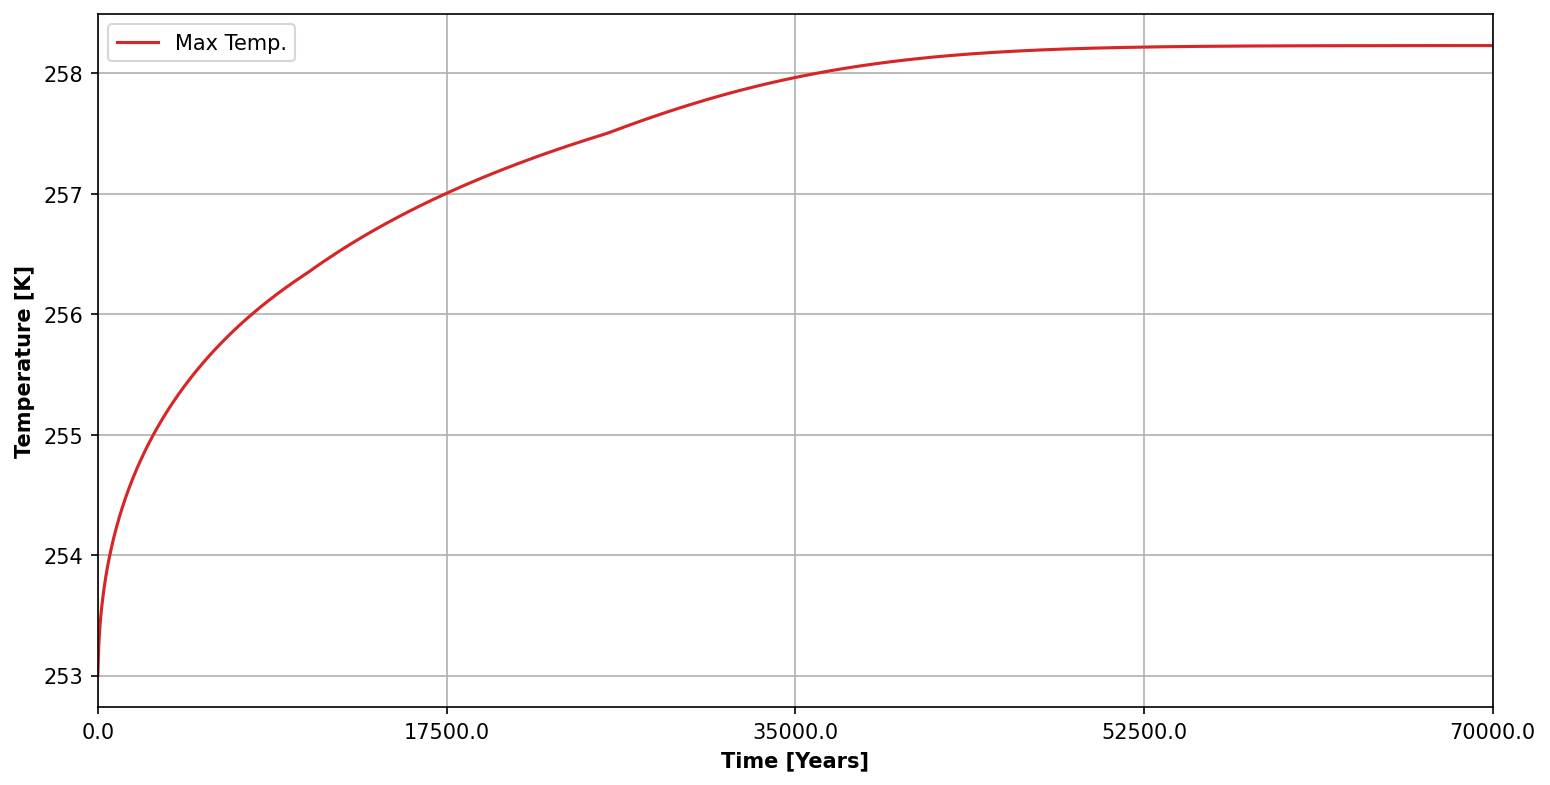

In [23]:
fig, ax = plt.subplots(figsize = (12, 6),dpi=150)
ax.plot(T_max, color = 'tab:red', label = 'Max Temp.')
#ax.plot(T_min, color = 'tab:blue', label = 'Min Temp.')

# if you don't do this:
ax.set_xticks( np.linspace(0,1400,5), np.linspace(0,len(T_max)*50,5) ) # 50 = dt here, but dt isn't an integer :(
# then the x axis is actually just the index of the T_max vector. The above line converts it to years again.
ax.set_xlabel('Time [Years]', fontweight = 'bold')
ax.set_ylabel('Temperature [K]', fontweight = 'bold')
ax.set_xlim(0,len(T_max))
ax.legend()
plt.grid()
#plt.savefig('q-val-0_b-val-90_tempvtime.png') 
plt.show();

258.22966115366876


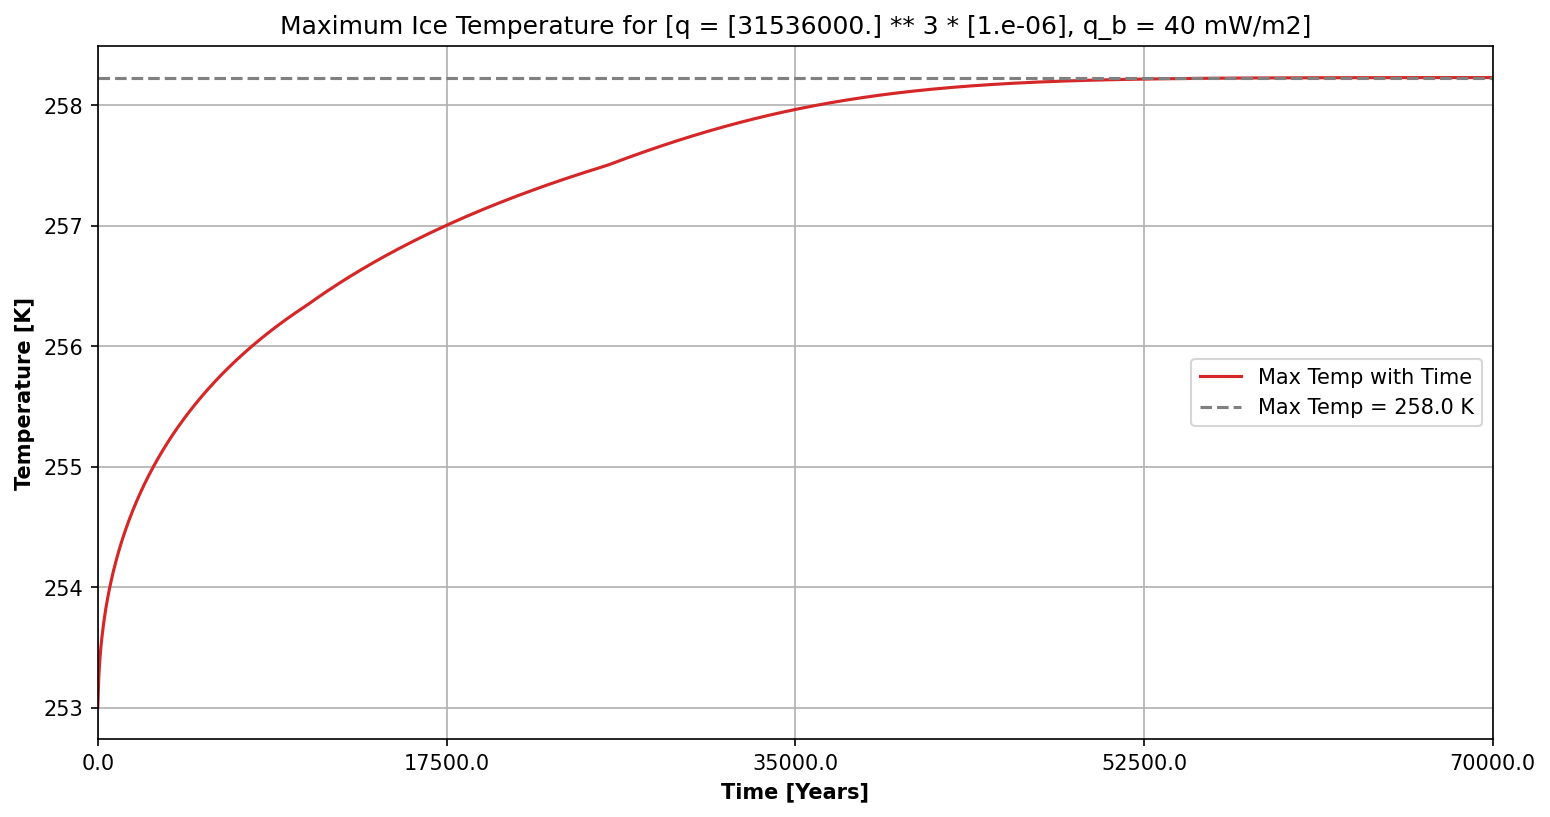

In [ ]:
# housekeeping for recording things:
maxmax = max(T_max)
print(maxmax)
fluxes = [40,50,60]
maxes  = [258.22966115366876,264.5713558187184,271.05893231047577]
filing = np.savetxt(fname=f'max-temps-q_b-{b_value}.csv',X=T_max)

# ok go crazy, etc.:
fig, ax = plt.subplots(figsize = (12, 6),dpi=150)
ax.plot(T_max, color = 'tab:red', label = 'Max Temp with Time')
ax.hlines(maxmax,xmin=0,xmax=len(T_max),linestyle='dashed',color='gray',label=f'Max Temp = {np.round(maxmax)} K')
ax.set_xticks( np.linspace(0,1400,5), np.linspace(0,len(T_max)*50,5) ) # 50 = dt here, but dt isn't an integer :(
ax.set_xlabel('Time [Years]', fontweight = 'bold')
ax.set_ylabel('Temperature [K]', fontweight = 'bold')
ax.set_xlim(0,len(T_max))
ax.legend(loc='right')
plt.grid()
plt.title(f"Maximum Ice Temperature for [q = {q}, q_b = {b_value} mW/m2]")
#plt.savefig('q-val-0_b-val-90_tempvtime.png') 
plt.show();

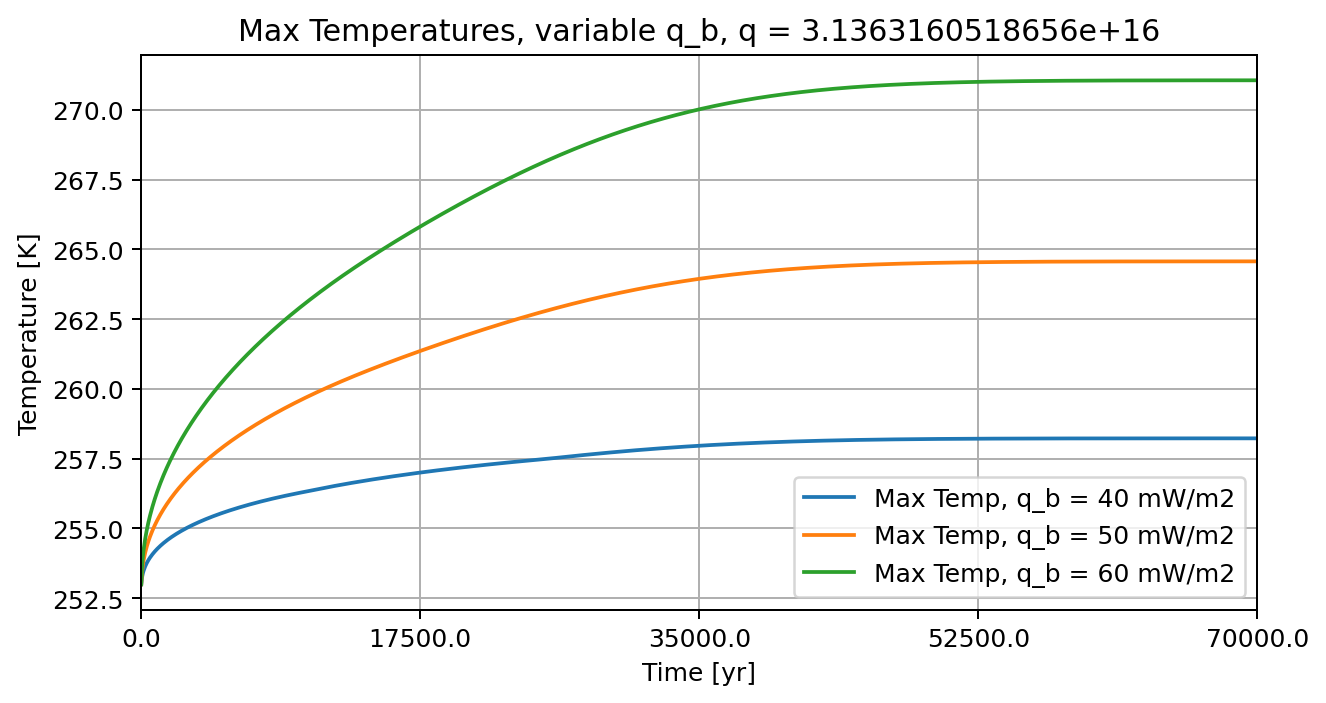

In [39]:
# make a cute little plot i guess:
tm40 = np.loadtxt('max-temps-q_b-40.csv')
tm50 = np.loadtxt('max-temps-q_b-50.csv')
tm60 = np.loadtxt('max-temps-q_b-60.csv')

# other things:

plt.figure(figsize=(8,4),dpi=180)
plt.plot(tm40,label='Max Temp, q_b = 40 mW/m2')
plt.plot(tm50,label='Max Temp, q_b = 50 mW/m2')
plt.plot(tm60,label='Max Temp, q_b = 60 mW/m2')
plt.xlabel('Time [yr]')
plt.ylabel('Temperature [K]')
plt.title(f'Max Temperatures, variable q_b, q = {(31536000.0**3)*1e-6}') # NB: this q = (31536000.0**3)*1e-6
plt.xlim(0,len(T_max))
plt.xticks(np.linspace(0,1400,5), np.linspace(0,len(T_max)*50,5))
plt.grid()
plt.legend()
plt.show();

In [25]:
### This is a video of the run. These videos are a great way to check if things are running in a way that makes sense